In [1]:
import sys
sys.path.insert(0, "./src/")

# 00-Sanity-checks

Run sanity checks for attacks and data modification.

In [8]:
import tqdm
import os

import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from src.utils.data_utils import get_cifar10_data
from src.utils.adversary_utils import adv_attack
from src.utils.vis_utils import vis_pred

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
data = get_cifar10_data(32, img_size=32, subsample=True)
classes = data["classes"]
_, val_laoder = data["val"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(os.path.join(r"ckpts\standard_d_v15\best.pt")))
#model.fc = nn.Identity()
model.to("cuda");
model.eval();

In [6]:
adversary_param_linf = {"steps": 1, #1000,
                           "epsilon": 8/255,
                           "alpha": 2/255}

adversary_param_l2 = {"steps": 10,
                      "epsilon": 0.5,
                      "alpha": 0.1}

adversary_param = adversary_param_linf

## 1. Closer look at attack

In [11]:
data = get_cifar10_data(1, img_size=32, subsample=True)
classes = data["classes"]
_, val_laoder = data["val"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [12]:
from torchattacks import PGDL2
atk = PGDL2(model, eps=0.5, alpha=0.1, steps=5, random_start=False)
atk.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%10)

Attack mode is changed to 'targeted(custom)'.


In [13]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(os.path.join(r"ckpts\standard_d_v9\best.pt")))
model.to("cuda");
model.eval();

True label:  cat
Prediced label on original image:  cat
Prediction after adv attack 1:  dog


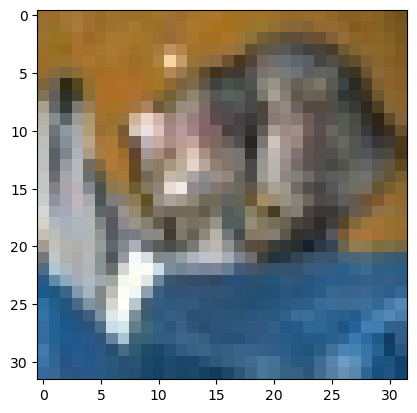

In [24]:
for batch in test_loader:
    pred = model(batch[0].to("cuda")).argmax(1)
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=10, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediced label on original image: ", classes[pred])
    print("Prediction after adv attack 1: ", classes[adv])
    break

True label:  cat
Prediction after adv attack 1:  dog


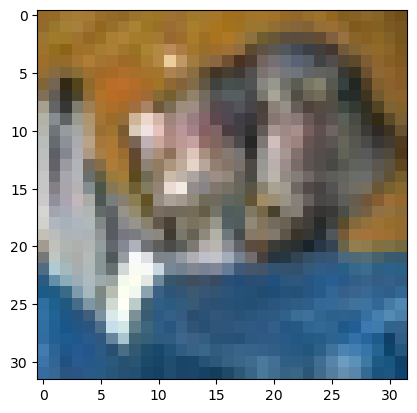

In [23]:
for batch in test_loader:
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=1, steps=20, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediction after adv attack 1: ", classes[adv])
    break

## 2. Compare prediction of model before and after attack

In [44]:
data = get_cifar10_data(1, img_size=32, subsample=True)
classes = data["classes"]
_, val_laoder = data["val"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [45]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(os.path.join(r"ckpts\standard_d_v15\best.pt")))
model.to("cuda");
model.eval();

#### Untargeted L-infinity Attack

In [27]:
from torchattacks import PGD

atk = PGD(model, eps=8/255, alpha=2/225, steps=7, random_start=False)

conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [06:05<00:00,  6.83it/s]

tensor([[  11., 2125.],
        [   0.,  364.]])


In [28]:
from captum.robust import PGD
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
pgd = PGD(model, nn.CrossEntropyLoss(reduction="none"), lower_bound=0, upper_bound=1)
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0].to("cuda"), batch[1].to("cuda")
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = pgd.perturb(x, radius=8/255, step_size=2/255, step_num=7, target=y)
    pred_adv = model(adv_batch.to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:26<00:00,  7.66it/s]

tensor([[  12., 2124.],
        [   0.,  364.]])


In [29]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=8/255, steps=7, alpha=2/255, norm="linf")
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:58<00:00,  6.97it/s]

tensor([[  14., 2122.],
        [   0.,  364.]])


#### Untargted L-2 attack

In [30]:
from torchattacks import PGDL2

atk = PGDL2(model, eps=0.5, steps=7, alpha=0.1, random_start=False)
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:19<00:00,  7.84it/s]

tensor([[ 290., 1846.],
        [   0.,  364.]])


In [31]:
from torchattacks import PGDL2

atk = PGDL2(model, eps=0.5, steps=7, alpha=0.1, random_start=True)
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:23<00:00,  7.73it/s]

tensor([[ 343., 1793.],
        [   0.,  364.]])


In [32]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=7, alpha=0.1, norm="l2", random_start=False, clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:22<00:00,  7.76it/s]

tensor([[ 290., 1846.],
        [   0.,  364.]])


In [46]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=1, steps=20, alpha=0.1, norm="l2", random_start=False, clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [19:47<00:00,  2.10it/s]

tensor([[  13., 2123.],
        [   0.,  364.]])


In [33]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=7, alpha=0.1, norm="l2", random_start=True, clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:22<00:00,  7.75it/s]

tensor([[ 538., 1598.],
        [   0.,  364.]])


#### Targeted attacks L-infinity attack

In [34]:
from torchattacks import PGD

atk = PGD(model, eps=8/255, alpha=2/225, steps=7, random_start=False)
atk.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%10)

conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

Attack mode is changed to 'targeted(custom)'.


100%|██████████| 2500/2500 [05:14<00:00,  7.95it/s]

tensor([[ 101., 2035.],
        [   3.,  361.]])


In [35]:
from captum.robust import PGD
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
pgd = PGD(model, nn.CrossEntropyLoss(reduction="none"), lower_bound=0, upper_bound=1)
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0].to("cuda"), batch[1].to("cuda")
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = pgd.perturb(x, radius=8/255, step_size=2/255, step_num=7, targeted=True, target=(y+1)%10)
    pred_adv = model(adv_batch.to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:22<00:00,  7.76it/s]

tensor([[1.1600e+02, 2.0200e+03],
        [2.0000e+00, 3.6200e+02]])


In [36]:
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=(batch[1]+1) % 10, epsilon=8/255, steps=7, alpha=2/225, norm="linf", clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:15<00:00,  7.91it/s]

tensor([[ 101., 2035.],
        [   3.,  361.]])


#### Targeted attacks L-2 attack

In [37]:
from torchattacks import PGDL2

atk = PGDL2(model, eps=0.5, steps=7, alpha=0.1, random_start=False)
atk.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%10)

conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

Attack mode is changed to 'targeted(custom)'.


100%|██████████| 2500/2500 [05:25<00:00,  7.68it/s]

tensor([[ 832., 1304.],
        [  15.,  349.]])


In [38]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=(batch[1]+1) % 10, epsilon=0.5, steps=7, alpha=0.1, norm="l2", random_start=False, clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [05:19<00:00,  7.82it/s]

tensor([[ 832., 1304.],
        [  15.,  349.]])


Assert that it is stronger with larger epsilon.

In [47]:
from torchattacks import PGDL2

atk = PGDL2(model, eps=1, steps=20, alpha=0.1, random_start=False)
atk.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%10)

conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = atk(batch[0], batch[1])
    pred_adv = model(adv_batch[0].unsqueeze(0).to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

Attack mode is changed to 'targeted(custom)'.


100%|██████████| 2500/2500 [21:15<00:00,  1.96it/s]

tensor([[1.1300e+02, 2.0230e+03],
        [1.0000e+00, 3.6300e+02]])


In [48]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=(batch[1]+1) % 10, epsilon=1, steps=20, alpha=0.1, norm = "l2", clip_adv_input=True)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [21:04<00:00,  1.98it/s]

tensor([[1.1200e+02, 2.0240e+03],
        [1.0000e+00, 3.6300e+02]])


## 3. Make sure pertubations only are in epsilon norm range

In [41]:
BS = 64
data = get_cifar10_data(BS, img_size=32, subsample=True)
classes = data["classes"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [42]:
for eps in tqdm.tqdm([0.5, 1, 5]):
    for batch in tqdm.tqdm(test_loader):
        x = batch[0]
        if x.shape[0] == BS: # skip last incomplete batch
            adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=torch.randint(low=0, high=5, size=(64,)).type(torch.LongTensor) , epsilon=eps, steps=7, alpha=0.1)
            assert(torch.all((x-adv_batch[0]).reshape(x.shape[0],-1).norm(p=2, dim=-1) <= eps + 1e-6))
print("All modifications are within maximum allowed norm.")

100%|██████████| 3/3 [00:16<00:00,  5.54s/it]

All modifications are within maximum allowed norm.
